# Customer Segmentation and Basket Affinity Modelling

This notebook performs an analysis on customer transaction data to achieve two main goals: customer segmentation and basket affinity modelling. Customer segmentation is performed using RFM (Recency, Frequency, Monetary) analysis followed by K-Means clustering to group customers based on their purchasing behavior. Basket affinity modelling uses the Apriori algorithm to discover association rules between items frequently bought together, which can inform product placement, promotions, and recommendations.



## Notebook Structure

The notebook is structured into the following main sections:

-   **Data Processing**: This section covers importing the dataset, initial data exploration, and handling missing values.
-   **RFM Analysis**: This section focuses on calculating Recency, Frequency, and Monetary values for each customer.
-   **PCA (Principal Component Analysis)**: This section applies PCA to reduce the dimensionality of the RFM features for easier visualization and potentially improved clustering performance.
-   **K-Means Clustering**: This section implements K-Means clustering on the RFM (or PCA-transformed RFM) data to group customers into distinct segments, including finding the optimal number of clusters.
-   **Basket Affinity Modelling**: This section prepares the data for association rule mining and applies the Apriori algorithm to find frequent itemsets and generate association rules.

## Key Steps and Findings

### Data Processing

- **Data Loading**: The dataset was downloaded directly from Kaggle using the `kagglehub` library and loaded into a pandas DataFrame.
- **Initial Exploration**: Basic data exploration was performed using `.info()`, `.describe()`, and `.isnull().sum()` to understand the dataset structure, summary statistics, and check for missing values. The dataset was found to have no missing values.
- **Date Conversion**: The 'Date' column was converted to datetime objects to facilitate time-based calculations for RFM analysis.

### RFM Analysis

RFM analysis was conducted to segment customers based on their transactional behavior.
- **Recency**: Calculated as the number of days between each customer's last purchase date and the most recent date in the dataset.
- **Frequency**: Computed as the number of unique purchase dates for each customer.
- **Monetary**: Determined by counting the total number of items purchased by each customer.
These three metrics were combined into a single DataFrame `rfm`.

### PCA (Principal Component Analysis)

- **Purpose**: PCA was applied to the scaled RFM data to reduce its dimensionality to two principal components (PC1 and PC2) while retaining most of the original variance. This is useful for visualizing the customer segments in a 2D space.
- **Explained Variance**: The explained variance ratio showed that PC1 captures the majority of the variance in the RFM data, and PC2 captures a significant portion of the remaining variance. This indicates that the two components effectively represent the underlying patterns in the RFM metrics.
- **Feature Contributions**: The PCA weights revealed how much each original RFM feature (Recency, Frequency, Monetary) contributes to the principal components. For instance, PC1 is heavily influenced by Frequency and Monetary values (both with positive weights), while PC2 is strongly related to Recency (with a positive weight).

### K-Means Clustering

- **Optimal K**: The Elbow method (plotting Inertia vs. K) and Silhouette scores were used to determine the optimal number of clusters. Based on the Silhouette scores, K=5 was selected as the best number of clusters for the dataset, as it yielded the highest score among the evaluated range.
- **Model Fitting and Visualization**: A K-Means model with 5 clusters was fitted to the scaled RFM data (or PCA-transformed data). Cluster labels were assigned to the `rfm` and `pca_df` DataFrames. The clusters were visualized on the PCA-transformed data, showing visually distinct groupings of customers.
- **Cluster Profiling**: The mean RFM values were calculated for each cluster (`cluster_profile`). This analysis helps to understand the characteristics of each segment. For example, clusters with low Recency and high Frequency/Monetary values represent recent, frequent, and high-spending customers (likely the most valuable segment), while clusters with high Recency and low Frequency/Monetary values represent dormant or low-value customers.



### Basket Affinity Modelling

- **Data Transformation**: The transaction data (customer number, date, and item description) was transformed into a one-hot encoded format where each row represents a transaction (customer and date combination) and each column represents a unique item, indicating whether that item was present in the transaction.
- **Frequent Itemsets**: The Apriori algorithm was applied to the encoded transaction data with a `min_support` of 0.001 to find items or sets of items that frequently appear together in transactions.
- **Association Rules**: Association rules were generated from the frequent itemsets using a `min_threshold` of 0.1 for the `confidence` metric. The `lift` metric was used to evaluate the strength and relevance of the rules. Rules with a lift greater than 1 indicate that the items in the consequent are more likely to be bought when the items in the antecedent are also bought, compared to their individual probabilities.
- **Rule Interpretation**: The scatter plot of confidence vs. lift visualizes the trade-off between these two metrics and the support of the rules. The heatmap of the top rules sorted by lift provides a clear visual representation of the strongest associations between specific item sets. For instance, a high lift value between "sausage" and "yogurt" suggests that customers buying sausage are significantly more likely to also buy yogurt.
- **Interactive Consequent Finder**: An interactive widget was created to allow users to select one or more items and find the associated items (consequents) based on the generated rules, along with their support, confidence, and lift values.



## How to Run the Notebook

1.  **Obtain the Data**: The dataset is available on Kaggle. The notebook uses the `kagglehub` library to download the dataset directly. Ensure you have a Kaggle account and the necessary credentials configured for `kagglehub` to work. The data file used is `Groceries data.csv`.

2.  **Install Dependencies**: The notebook requires the following Python libraries. You can install them using pip:
    ```bash
    pip install pandas numpy matplotlib scikit-learn mlxtend kagglehub seaborn ipywidgets networkx
    ```

3.  **Execute the Notebook**: You can run this notebook using Jupyter Notebook or JupyterLab. Simply open the `.ipynb` file in either environment and run the cells sequentially.


#Customer Segmentation

## 1.   Importing Dependencies




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2.   Data Processing

### Step 2.1: Import data set from Kaggle

We will be using a data set from Kaggle

https://www.kaggle.com/datasets/rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rashikrahmanpritom/groceries-dataset-for-market-basket-analysismba")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/groceries-dataset-for-market-basket-analysismba


### Step 2.2: Locate the file

In [ ]:
import os
print(os.listdir())  # List files in the current directory
print(os.listdir(path))  # Check files inside the dataset folder

['.config', 'sample_data']
['Groceries data.csv', 'basket.csv']


### Step 2.3: Loading the file

In [ ]:
print(str(os.listdir(path)[0]))

Groceries data.csv


In [ ]:
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, str(os.listdir(path)[0])))  # Changed line to read the CSV file
df.head()

Path to dataset files: /kaggle/input/groceries-dataset-for-market-basket-analysismba


,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4


In [ ]:
df.dropna()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,1808,2015-07-21,tropical fruit,2015,7,21,1
1,2552,2015-05-01,whole milk,2015,5,1,4
2,2300,2015-09-19,pip fruit,2015,9,19,5
3,1187,2015-12-12,other vegetables,2015,12,12,5
4,3037,2015-01-02,whole milk,2015,1,2,4
...,...,...,...,...,...,...,...
38760,4471,2014-08-10,sliced cheese,2014,8,10,6
38761,2022,2014-02-23,candy,2014,2,23,6
38762,1097,2014-04-16,cake bar,2014,4,16,2
38763,1510,2014-03-12,fruit/vegetable juice,2014,3,12,2


In [ ]:
# 🧾 Dataset information
print(df.info())
print()

# 📊 Descriptive statistics for all columns
print(df.describe().T)
print()

# 🔍 Check for missing values in the dataset
print(df.isnull().sum())
print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
 3   year             38765 non-null  int64 
 4   month            38765 non-null  int64 
 5   day              38765 non-null  int64 
 6   day_of_week      38765 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB
None

                 count         mean          std     min     25%     50%  \
Member_number  38765.0  3003.641868  1153.611031  1000.0  2002.0  3005.0   
year           38765.0  2014.528518     0.499193  2014.0  2014.0  2015.0   
month          38765.0     6.477570     3.431561     1.0     4.0     6.0   
day            38765.0    15.753231     8.801391     1.0     8.0    16.0   
day_of_week    38765.0     3.014498     1.987669   

### Step 2.4: RFM

In [ ]:
# Group by customer
frequency = df.groupby('Member_number')['Date'].nunique()
print(frequency.head())

Member_number
1000    5
1001    5
1002    4
1003    4
1004    8
Name: Date, dtype: int64


In [ ]:
monetary = df.groupby('Member_number')['itemDescription'].count()
print(monetary.head())

Member_number
1000    13
1001    12
1002     8
1003     8
1004    21
Name: itemDescription, dtype: int64


In [ ]:
# 1. Convert Date to datetime
# print(df['Date'].head())

df['Date'] = pd.to_datetime(df['Date'])

# print(df['Date'].head())

# 2. Get the max date in the dataset
max_date = df['Date'].max()

# 3. Compute last purchase date per customer
last_purchase = df.groupby('Member_number')['Date'].max()

# 4. Compute recency (days since last purchase)
recency = (max_date - last_purchase).dt.days

print(recency.head())


Member_number
1000     35
1001    260
1002    122
1003     89
1004    321
Name: Date, dtype: int64


In [ ]:
# Combine into one DataFrame
rfm = pd.DataFrame({
    'Recency': recency,
    'Frequency': frequency,
    'Monetary': monetary
})

print(rfm.head())

               Recency  Frequency  Monetary
Member_number                              
1000                35          5        13
1001               260          5        12
1002               122          4         8
1003                89          4         8
1004               321          8        21


### Data scaling for K-Means CLustering

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Optional: Convert back to DataFrame for readability
rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print(rfm_scaled_df.head())

                Recency  Frequency  Monetary
Member_number                               
1000          -0.938290   0.616620  0.575347
1001           0.450999   0.616620  0.387027
1002          -0.401098   0.085676 -0.366253
1003          -0.604860   0.085676 -0.366253
1004           0.827650   2.209453  2.081905


## PCA (Principal Component Analysis)


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)

# Create DataFrame for visualization
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'], index=rfm.index)

print(pca_df.head())

# Optional: see explained variance
print("Explained Variance Ratio:", pca.explained_variance_ratio_)


                    PC1       PC2
Member_number                    
1000           1.172915 -0.462955
1001           0.433450  0.722920
1002           0.000686 -0.442108
1003           0.091617 -0.624427
1004           2.345971  2.096121
Explained Variance Ratio: [0.73815902 0.23273087]


In [ ]:
# Show feature contributions to each principal component
pca_weights = pd.DataFrame(
    pca.components_,
    columns=['Recency', 'Frequency', 'Monetary'],  # or use rfm.columns[:3]
    index=['PC1', 'PC2']
)

print(pca_weights.T)

                PC1       PC2
Recency   -0.446258  0.894762
Frequency  0.631108  0.327287
Monetary   0.634474  0.303782


In [ ]:
from sklearn.cluster import KMeans

# Apply the best config to your actual data
kmeans_final = KMeans(n_clusters=6, random_state=2024, n_init='auto')
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled_df)

# Optional for PCA plotting
pca_df['Cluster'] = rfm['Cluster']

## 3.   K-Means Clustering

### Step 3.1: Optimal K

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

best_k = None
best_score = -1
scores = []

rs_value = 2042

for k in range(4,16):  # Check from K=6 to K=15
    kmeans = KMeans(n_clusters=k, random_state=rs_value, n_init='auto')
    labels = kmeans.fit_predict(pca_df)  # Or rfm_scaled_df if you prefer
    score = silhouette_score(pca_df, labels)
    scores.append((k, score))

    print(f"K={k} | Silhouette Score = {score:.4f}")

    if score > best_score:
        best_k = k
        best_score = score

print(f"\n✅ Best K = {best_k} with Silhouette Score = {best_score:.4f}")

K=4 | Silhouette Score = 0.5134
K=5 | Silhouette Score = 0.5634
K=6 | Silhouette Score = 0.5013
K=7 | Silhouette Score = 0.4544
K=8 | Silhouette Score = 0.4655
K=9 | Silhouette Score = 0.4304
K=10 | Silhouette Score = 0.4135
K=11 | Silhouette Score = 0.4129
K=12 | Silhouette Score = 0.4083
K=13 | Silhouette Score = 0.4027
K=14 | Silhouette Score = 0.4114
K=15 | Silhouette Score = 0.4079

✅ Best K = 5 with Silhouette Score = 0.5634


### Step 3.2: Model fitting

Cluster
0     583
1     595
2    1142
3     616
4     962
Name: count, dtype: int64


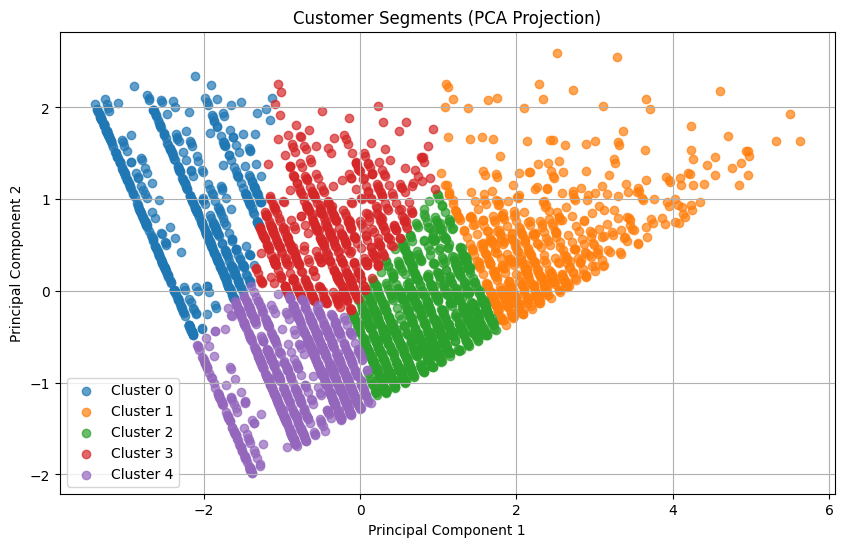

In [ ]:
from sklearn.cluster import KMeans

# Final model
# kmeans_final = KMeans(n_clusters=3, random_state=rs_value, n_init='auto')
# rfm['Cluster'] = kmeans_final.fit_predict(pca_df)

# Apply the best config to your actual data
kmeans_final = KMeans(n_clusters=best_k, random_state=47, n_init='auto')
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled_df)

# Optional: see how many customers per cluster
print(rfm['Cluster'].value_counts().sort_index())

import matplotlib.pyplot as plt

# Assign cluster labels to PCA dataframe
pca_df['Cluster'] = rfm['Cluster']

# Plot PCA with cluster color
plt.figure(figsize=(10, 6))
for cluster in sorted(pca_df['Cluster'].unique()):
    plt.scatter(
        pca_df[pca_df['Cluster'] == cluster]['PC1'],
        pca_df[pca_df['Cluster'] == cluster]['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.7
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Customer Segments (PCA Projection)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Group by cluster and get mean of RFM features
cluster_profile = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
print(cluster_profile)


         Recency  Frequency  Monetary
Cluster                              
0         470.55       1.76      4.11
1          94.05       6.95     18.88
2          86.89       4.58     11.89
3         305.88       3.78      9.55
4         115.21       2.33      5.90


# Basket Affinity Modelling


In [ ]:
import pandas as pd

transactions = df.groupby (['Member_number', 'Date'])['itemDescription'].apply(list)
transactions = transactions.reset_index(drop=True)

In [ ]:
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)

df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
df_encoded.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


##Aprori Alogrithm

In [ ]:
from mlxtend.frequent_patterns import apriori

frequent_itemsets = apriori(df_encoded, min_support=0.001, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
146,0.157923,(whole milk)
90,0.122101,(other vegetables)
109,0.110005,(rolls/buns)
123,0.097106,(soda)
147,0.085879,(yogurt)
...,...,...
162,0.001002,"(canned beer, beef)"
34,0.001002,(cooking chocolate)
105,0.001002,(ready soups)
725,0.001002,"(tropical fruit, sugar)"


In [ ]:
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
print(frequent_itemsets['length'].value_counts())

length
2    592
1    149
3      9
Name: count, dtype: int64


Association Rule

In [ ]:
from mlxtend.frequent_patterns import association_rules

# rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.1)
rules.sort_values(by='lift', ascending=False)

rules[['antecedents','consequents','support', 'confidence', 'lift']]

,antecedents,consequents,support,confidence,lift
0,(UHT-milk),(other vegetables),0.002139,0.100000,0.818993
1,(UHT-milk),(whole milk),0.002540,0.118750,0.751949
2,(beef),(whole milk),0.004678,0.137795,0.872548
3,(berries),(other vegetables),0.002673,0.122699,1.004899
4,(berries),(whole milk),0.002272,0.104294,0.660414
...,...,...,...,...,...
125,"(soda, sausage)",(whole milk),0.001069,0.179775,1.138374
126,"(whole milk, sausage)",(soda),0.001069,0.119403,1.229612
127,"(yogurt, whole milk)",(sausage),0.001470,0.131737,2.182917
128,"(yogurt, sausage)",(whole milk),0.001470,0.255814,1.619866


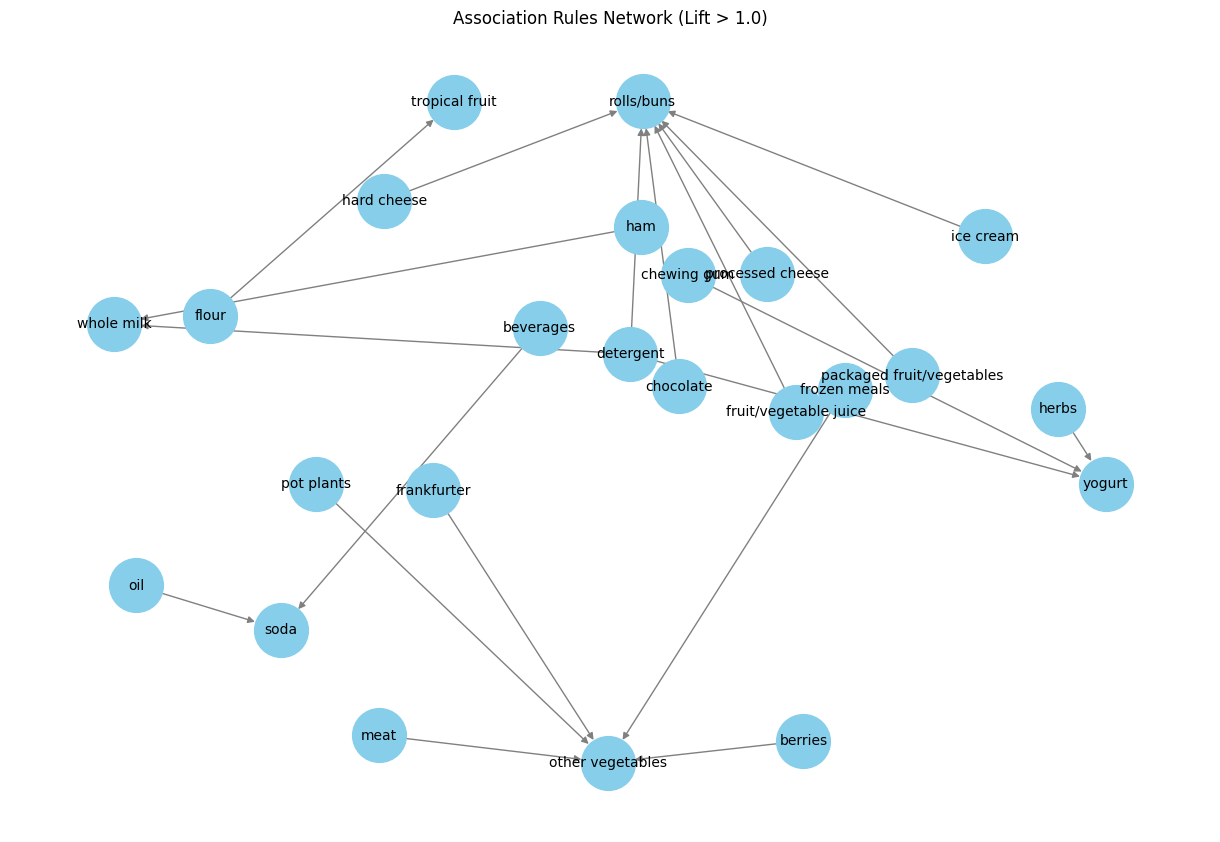

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Use a few top rules for clarity
top_rules = rules[rules['lift'] > 1.0].head(20)

G = nx.DiGraph()

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='skyblue', font_size=10, edge_color='gray', arrows=True)

plt.title('Association Rules Network (Lift > 1.0)')
plt.show()


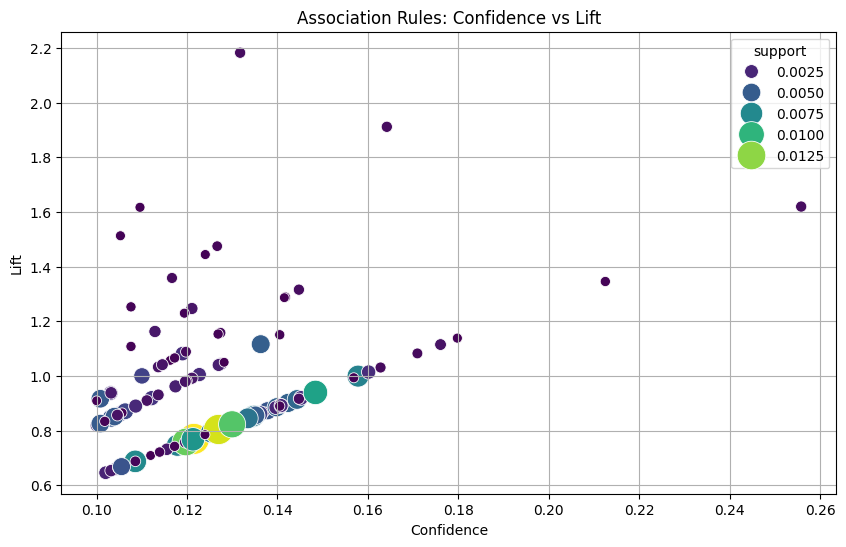

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=rules, x='confidence', y='lift', size='support', hue='support', palette='viridis', sizes=(50, 500))
plt.title('Association Rules: Confidence vs Lift')
plt.xlabel('Confidence')
plt.ylabel('Lift')
plt.grid(True)
plt.show()


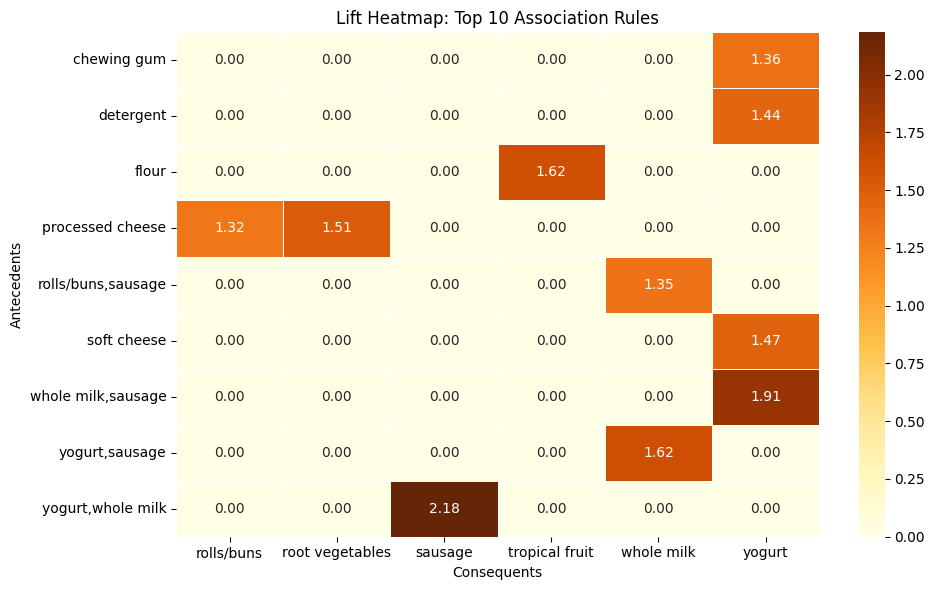

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Sort rules by lift and keep top 10
top_rules = rules.sort_values(by='lift', ascending=False).head(10)

# Step 2: Convert frozen sets to strings for readability
top_rules['antecedents_str'] = top_rules['antecedents'].apply(lambda x: ','.join(list(x)))
top_rules['consequents_str'] = top_rules['consequents'].apply(lambda x: ','.join(list(x)))

# Step 3: Create pivot table
pivot = top_rules.pivot(index='antecedents_str', columns='consequents_str', values='lift')
pivot = pivot.fillna(0)

# Step 4: Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlOrBr", linewidths=0.5)
plt.title('Lift Heatmap: Top 10 Association Rules')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.tight_layout()
plt.show()

In [ ]:
# pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def find_consequents_interactive(rules_df, unique_items):
    # Dropdowns for selecting up to 3 items
    item1 = widgets.Dropdown(options=[''] + sorted(unique_items), description='Item 1:')
    item2 = widgets.Dropdown(options=[''] + sorted(unique_items), description='Item 2:')
    item3 = widgets.Dropdown(options=[''] + sorted(unique_items), description='Item 3:')

    output = widgets.Output()

    def on_change(change):
        with output:
            output.clear_output()
            selected_items = set(filter(None, [item1.value, item2.value, item3.value]))
            if not selected_items:
                print("Please select at least one item.")
                return

            # Filter rules where antecedents exactly match selected_items
            matched_rules = rules_df[rules_df['antecedents'].apply(lambda x: selected_items.issubset(x))]

            if matched_rules.empty:
                print(f"No matching rules found for: {', '.join(selected_items)}")
            else:
                display(matched_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))

    # Attach the update function to changes
    item1.observe(on_change, names='value')
    item2.observe(on_change, names='value')
    item3.observe(on_change, names='value')

    # Display the UI
    display(widgets.VBox([item1, item2, item3, output]))

In [ ]:
all_items = sorted(set().union(*rules['antecedents']).union(*rules['consequents']))


In [ ]:
find_consequents_interactive(rules, all_items)


## Summary:

### Data Analysis Key Findings

*   The notebook successfully performed customer segmentation using RFM analysis and K-Means clustering, identifying 5 distinct customer clusters based on their purchasing behavior.
*   PCA was applied to the RFM data, with PC1 and PC2 capturing the majority of the variance, primarily driven by Frequency, Monetary, and Recency metrics respectively.
*   Basket affinity modeling using the Apriori algorithm identified frequent itemsets and generated association rules with a minimum support of 0.001 and a minimum confidence of 0.1.
*   The analysis highlighted strong associations between certain items, indicated by high lift values in the association rules, such as between "sausage" and "yogurt".
*   An interactive tool was developed to allow users to explore item associations based on the generated rules.

### Insights or Next Steps

*   Use the identified customer segments to tailor marketing campaigns and product offerings to increase engagement and sales within each group.
*   Leverage the discovered association rules to optimize product placement in stores or online, create targeted promotions (e.g., "Customers who bought X also bought Y"), and improve recommendation systems.
